# Adjusting for class imbalance (more no flood than flood pixels in binary mask)


In [4]:
import tensorflow as tf
import numpy as np
import tifffile as tiff
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K
import tensorflow as tf

import glob
import cv2


# Load TIFF images correctly
def load_image(image_path):
    try:
        image = tiff.imread(image_path)  # Use tifffile instead of OpenCV
        if image is None:
            print(f" Failed to load image: {image_path}")
        return image
    except Exception as e:
        print(f" Error loading image {image_path}: {e}")
        return None

# Load masks correctly
def load_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    if mask is None:
        print(f" Failed to load mask: {mask_path}")
    else:
        mask = mask.astype(np.float32) / 255.0  # Normalize to 0-1
    return mask

# Adjust paths to correctly get images and masks
image_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/images/*.tif"))  # TIFF images
mask_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/labels/*.png"))  # PNG masks

print("Type of mask_paths:", type(mask_paths))
print("First mask path:", mask_paths[0] if isinstance(mask_paths, list) else mask_paths)

# Debugging: Check number of files
print(f"Found {len(image_paths)} image files")
print(f"Found {len(mask_paths)} mask files")

image_names = {p.split("/")[-1].split(".")[0] for p in image_paths}
mask_names = {p.split("/")[-1].split(".")[0] for p in mask_paths}
print("Images missing masks:", image_names - mask_names)
print("Masks missing images:", mask_names - image_names)
mask_paths_filtered = [p for p in mask_paths if p.split("/")[-1].split(".")[0] in image_names]
mask = np.array([load_mask(p) for p in mask_paths_filtered])

# Debugging: Check number of matched files
print(f"After filtering, {len(image_paths)} image files and {len(mask_paths_filtered)} mask files remain.")

# Load the images and masks
X_train = np.array([load_image(p) for p in image_paths])
Y_train = np.array([load_mask(p) for p in mask_paths_filtered])  # Use filtered masks
Y_train = (Y_train > 0).astype(np.uint8)  # Convert to 0s and 1s

# Expand dims if grayscale
if len(X_train.shape) == 3:  # (num_samples, height, width)
    X_train = np.expand_dims(X_train, axis=-1)  # (num_samples, height, width, 1)
    Y_train = np.expand_dims(Y_train, axis=-1)  # (num_samples, height, width, 1)

Y_train = np.expand_dims(Y_train, axis=-1)  # Shape becomes (306, 128, 128, 1)
print("Unique values in Y_train:", np.unique(Y_train))


# U-Net Model Definition
def unet_model(input_shape=(128, 128, 12)): 
    inputs = Input(input_shape)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)  # Binary segmentation

    model = Model(inputs, outputs)
    return model


def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou


class IoUCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\nEpoch {epoch+1}: IoU = {logs.get('iou_metric'):.4f}")


# Count flood (1s) vs. non-flood (0s)
flood_pixels = np.sum(Y_train == 1)
non_flood_pixels = np.sum(Y_train == 0)

print(f"Flood Pixels: {flood_pixels}, Non-Flood Pixels: {non_flood_pixels}")
print(f"Flood Coverage: {flood_pixels / (flood_pixels + non_flood_pixels):.4f}")

Type of mask_paths: <class 'list'>
First mask path: /kaggle/input/satalite1/satalite data/data/labels/0.png
Found 306 image files
Found 456 mask files
Images missing masks: set()
Masks missing images: {'110_287', '101_89', '49_64', '15_233', '134_153', '148_297', '103_225', '107_59', '108_236', '52_160', '25_172', '98_253', '3_74', '117_97', '37_118', '93_217', '65_203', '63_17', '115_49', '90_303', '62_187', '74_65', '146_84', '95_221', '44_191', '128_294', '26_274', '87_182', '104_20', '121_142', '79_161', '125_201', '47_15', '132_126', '123_145', '124_95', '4_300', '94_119', '149_166', '57_45', '61_206', '150_243', '2_215', '137_140', '10_244', '83_131', '28_2', '24_111', '81_9', '88_157', '5_275', '114_220', '120_305', '29_186', '67_156', '68_180', '75_52', '77_61', '59_132', '13_234', '71_120', '21_254', '22_16', '73_23', '60_245', '140_34', '142_238', '139_108', '51_91', '66_22', '96_154', '20_283', '131_185', '80_124', '97_130', '39_27', '145_164', '42_281', '11_116', '36_240', 

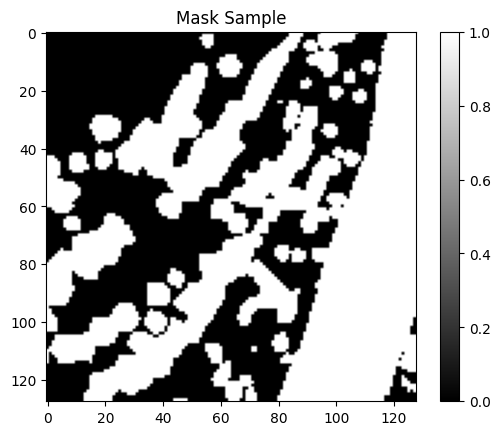

In [12]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(Y_train))  # Pick a random sample
plt.imshow(Y_train[idx], cmap="gray")
plt.title("Mask Sample")
plt.colorbar()
plt.show()


In [5]:
import torch

# Pixel counts
num_flood = 1302272
num_non_flood = 3711232
total_pixels = num_flood + num_non_flood

# Compute weights
weight_flood = total_pixels / (2 * num_flood)
weight_non_flood = total_pixels / (2 * num_non_flood)

# Convert to tensor for loss function
class_weights = torch.tensor([weight_non_flood, weight_flood], dtype=torch.float32).to("cuda")  # Use "cuda" if on GPU

print(class_weights)


tensor([0.6755, 1.9249], device='cuda:0')


In [7]:
def dice_loss(y_true, y_pred, weights):
    smooth = 1e-5
    y_pred = tf.keras.activations.sigmoid(y_pred)  # Ensure predictions are between 0 and 1

    # Flatten tensors for dice coefficient calculation
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice = (2.0 * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

    # Apply class weights (assuming binary segmentation)
    class_weights = tf.gather(weights, tf.cast(y_true_flat, tf.int32))  # Get weights for each pixel
    weighted_dice_loss = (1 - dice) * tf.reduce_mean(class_weights)

    return weighted_dice_loss


flood_weight = 1 / 0.2598  # ~3.85
non_flood_weight = 1 / 0.7402  # ~1.35
class_weights = tf.constant([non_flood_weight, flood_weight])  # Background=0, Flood=1


In [8]:
# Set input shape based on your dataset
input_shape = X_train.shape[1:]  # (height, width, channels)

# Initialize model
model = unet_model(input_shape)

# Compile model
#model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=[iou_metric])
# Compile U-Net model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=lambda y_true, y_pred: dice_loss(y_true, y_pred, class_weights),  
    metrics=[iou_metric]
)

# Print summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 12)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          6,976 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │        524,544 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 64, 64, 128)    │        131,200 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)    

 Total params: 7,702,529 (29.38 MB)

 Trainable params: 7,702,529 (29.38 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Define training parameters
batch_size = 8
epochs = 20

# Train the model
history = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[IoUCallback()]
)

# Save the trained model
model.save("unet_model.keras")


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - iou_metric: 0.2503 - loss: 1.2324
Epoch 1: IoU = 0.2764
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 407ms/step - iou_metric: 0.2511 - loss: 1.2319 - val_iou_metric: 0.2634 - val_loss: 1.2268
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - iou_metric: 0.3046 - loss: 1.2102
Epoch 2: IoU = 0.3662
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - iou_metric: 0.3065 - loss: 1.2095 - val_iou_metric: 0.5281 - val_loss: 1.1873
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - iou_metric: 0.6317 - loss: 1.1499
Epoch 3: IoU = 0.6138
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - iou_metric: 0.6312 - loss: 1.1498 - val_iou_metric: 0.5946 - val_loss: 1.1600
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - iou_metric: 0.6349 - loss: 1.1236
Epoch 4: IoU = 0.6045
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - iou_metric: 0.6339 - loss: 1.1241 - val_iou_metric: 0.6242 - val_loss: 1.1606
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - iou_metric: 0.5589 - loss: 1

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: dice_loss(y_true, y_pred, class_weights),  

  return {key: serialize_keras_object(value) for key, value in obj.items()}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


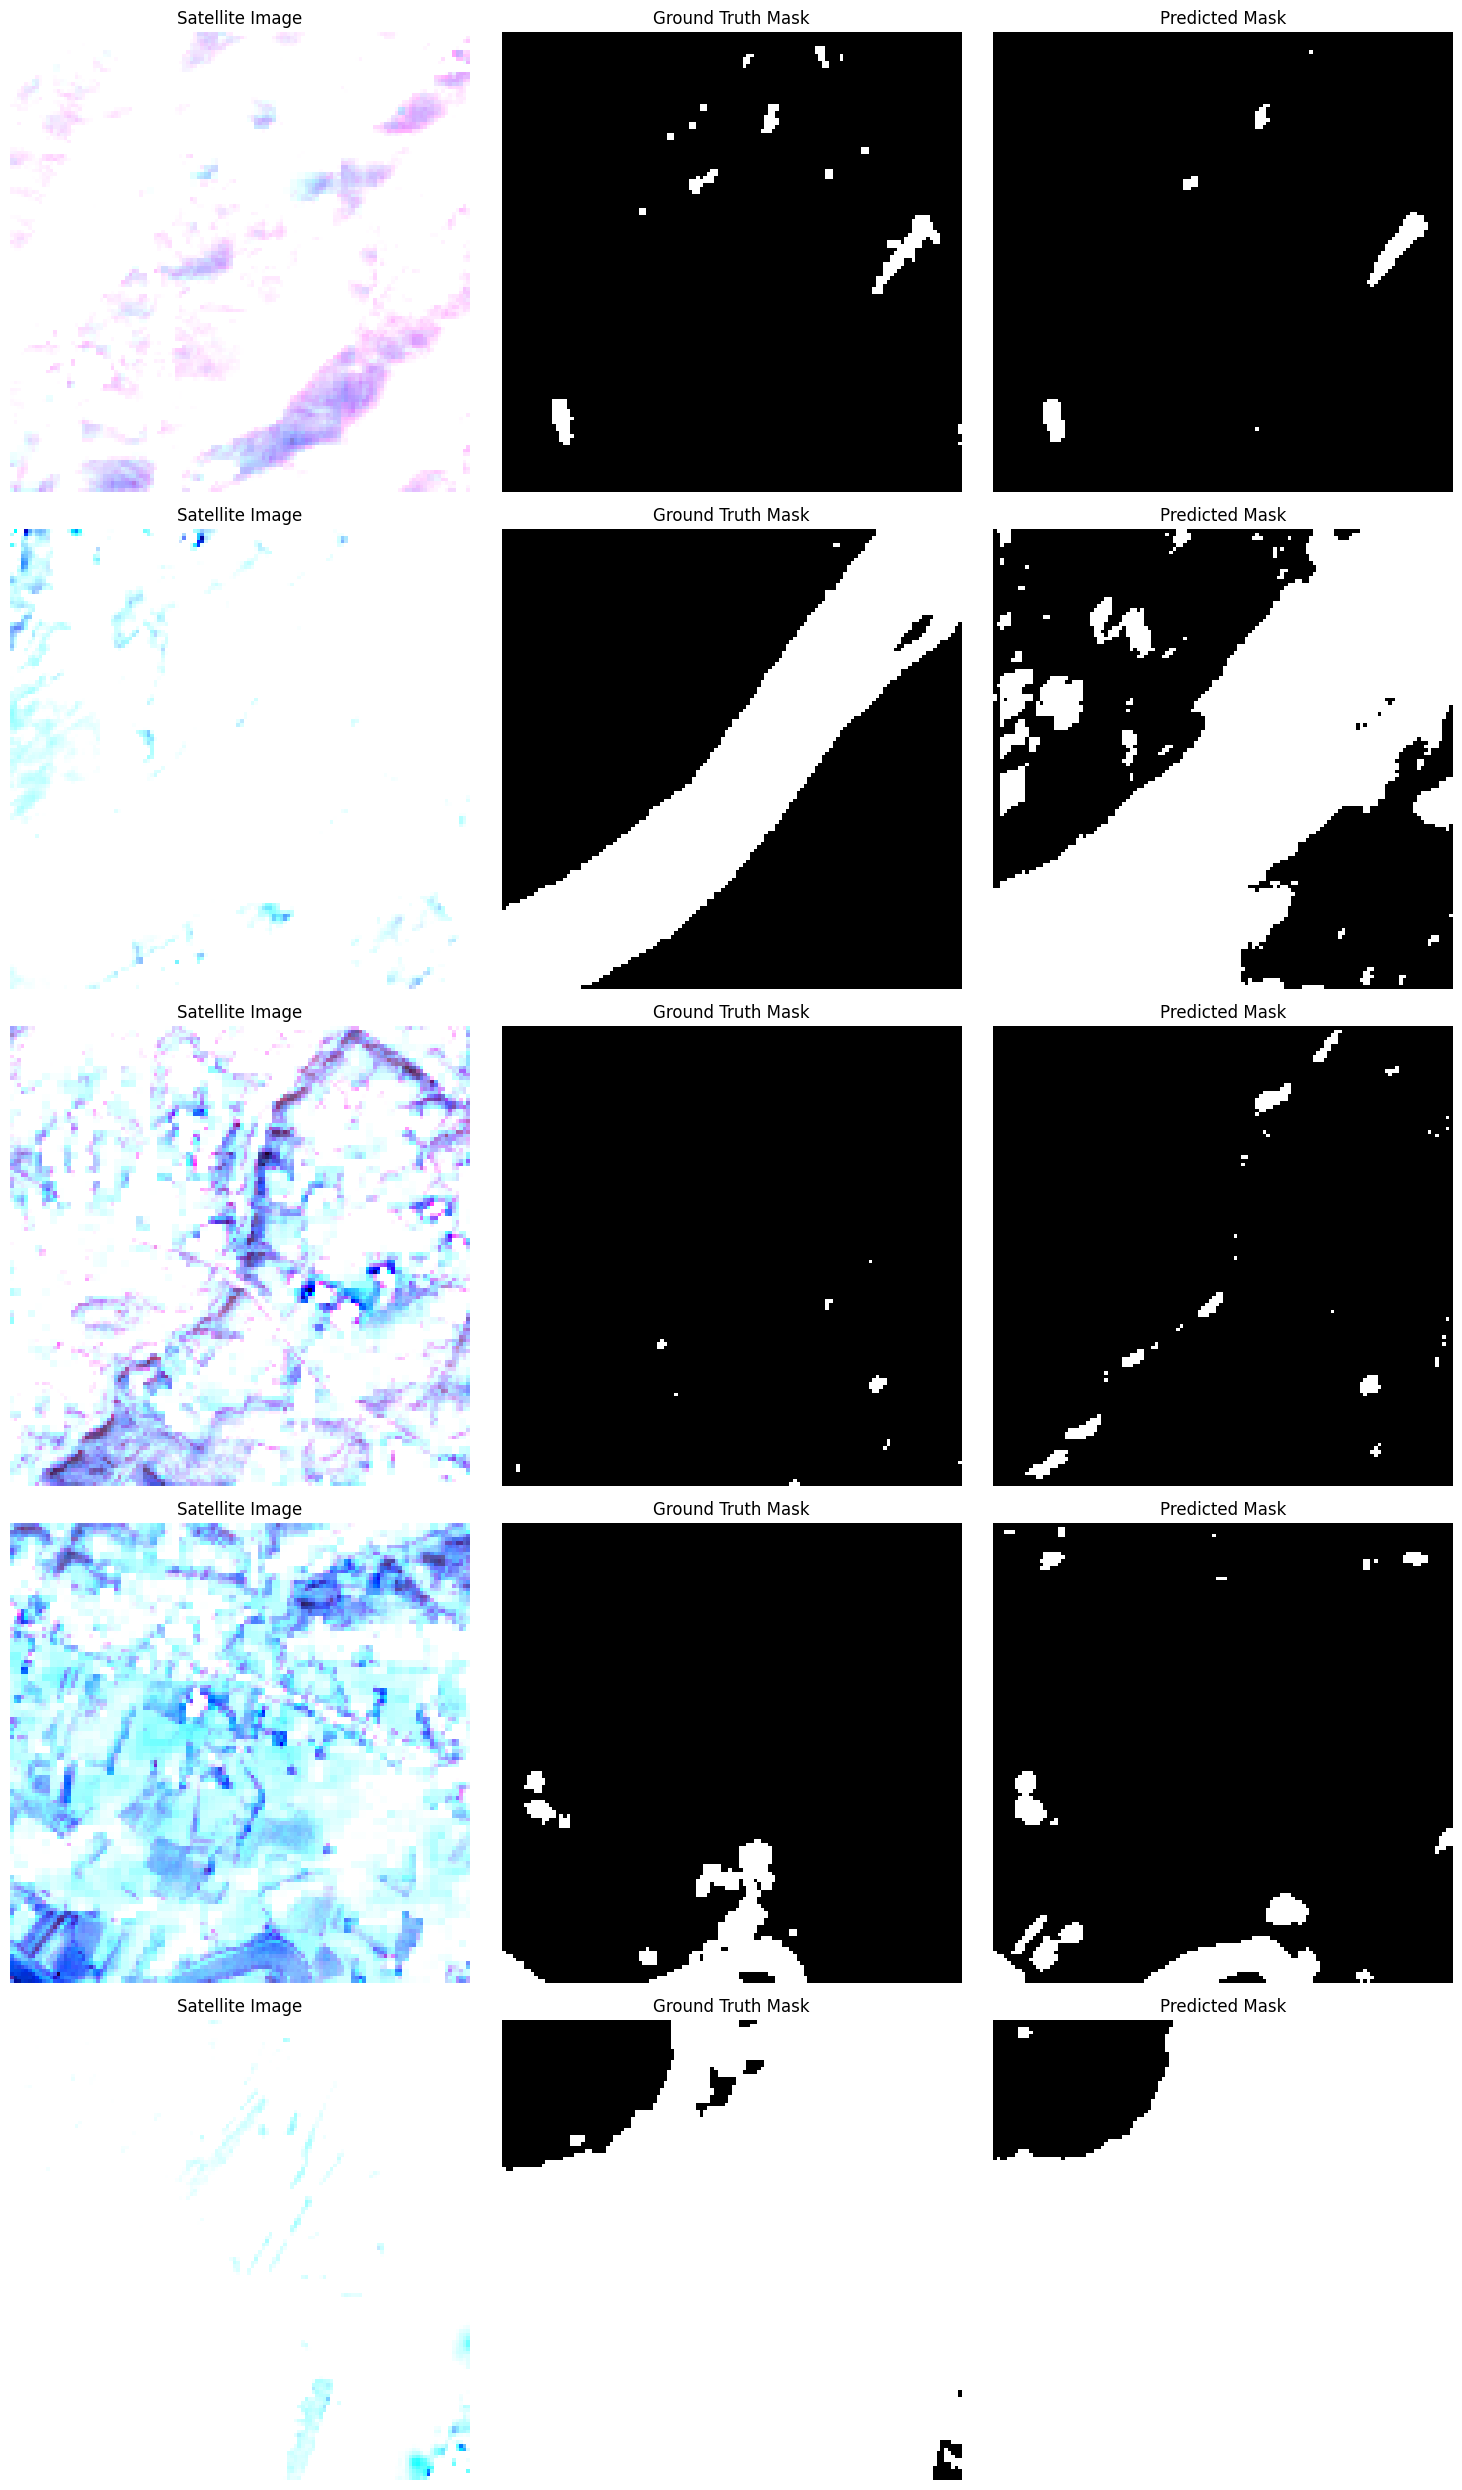

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(model, X, Y, num_samples=5, threshold=0.5):
    indices = np.random.choice(len(X), num_samples, replace=False)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices):
        image = X[idx]
        true_mask = Y[idx]

        # Predict flood mask using the trained model
        pred_mask = model.predict(image[np.newaxis, ...])  # Add batch dimension
        pred_mask = pred_mask.squeeze()  # Remove extra dimensions

        # Threshold to get binary mask (if needed)
        pred_mask = (pred_mask > threshold).astype(np.uint8)

        # Show satellite image
        axes[i, 0].imshow(image[:, :, :3])  # First 3 channels as RGB
        axes[i, 0].set_title("Satellite Image")
        axes[i, 0].axis("off")

        # Show ground truth mask
        axes[i, 1].imshow(true_mask.squeeze(), cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        # Show predicted mask
        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Call function
show_predictions(model, X_train, Y_train)


# Now adding BatchNormalization and Dropout(0.3)

In [2]:
import tensorflow as tf
import numpy as np
import tifffile as tiff
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from tensorflow.keras.layers import BatchNormalization, Dropout


import glob
import cv2


# Load TIFF images correctly
def load_image(image_path):
    try:
        image = tiff.imread(image_path)  # Use tifffile instead of OpenCV
        if image is None:
            print(f" Failed to load image: {image_path}")
        return image
    except Exception as e:
        print(f" Error loading image {image_path}: {e}")
        return None

# Load masks correctly
def load_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    if mask is None:
        print(f" Failed to load mask: {mask_path}")
    else:
        mask = mask.astype(np.float32) / 255.0  # Normalize to 0-1
    return mask

# Adjust paths to correctly get images and masks
image_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/images/*.tif"))  # TIFF images
mask_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/labels/*.png"))  # PNG masks

print("Type of mask_paths:", type(mask_paths))
print("First mask path:", mask_paths[0] if isinstance(mask_paths, list) else mask_paths)

# Debugging: Check number of files
print(f"Found {len(image_paths)} image files")
print(f"Found {len(mask_paths)} mask files")

image_names = {p.split("/")[-1].split(".")[0] for p in image_paths}
mask_names = {p.split("/")[-1].split(".")[0] for p in mask_paths}
print("Images missing masks:", image_names - mask_names)
print("Masks missing images:", mask_names - image_names)
mask_paths_filtered = [p for p in mask_paths if p.split("/")[-1].split(".")[0] in image_names]
mask = np.array([load_mask(p) for p in mask_paths_filtered])

# Debugging: Check number of matched files
print(f"After filtering, {len(image_paths)} image files and {len(mask_paths_filtered)} mask files remain.")

# Load the images and masks
X_train = np.array([load_image(p) for p in image_paths])
Y_train = np.array([load_mask(p) for p in mask_paths_filtered])  # Use filtered masks
Y_train = (Y_train > 0).astype(np.uint8)  # Convert to 0s and 1s

# Expand dims if grayscale
if len(X_train.shape) == 3:  # (num_samples, height, width)
    X_train = np.expand_dims(X_train, axis=-1)  # (num_samples, height, width, 1)
    Y_train = np.expand_dims(Y_train, axis=-1)  # (num_samples, height, width, 1)

Y_train = np.expand_dims(Y_train, axis=-1)  # Shape becomes (306, 128, 128, 1)
print("Unique values in Y_train:", np.unique(Y_train))


def unet_model(input_shape=(128, 128, 12), learning_rate=0.0001):  
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)  # Batch Norm
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.3)(p1)  # Dropout

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.3)(p2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.3)(p3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)  

    # Define Model
    model = Model(inputs, outputs)

    # Optimizer with Learning Rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[iou_metric])

    return model


def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou


class IoUCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\nEpoch {epoch+1}: IoU = {logs.get('iou_metric'):.4f}")


# Count flood (1s) vs. non-flood (0s)
flood_pixels = np.sum(Y_train == 1)
non_flood_pixels = np.sum(Y_train == 0)

print(f"Flood Pixels: {flood_pixels}, Non-Flood Pixels: {non_flood_pixels}")
print(f"Flood Coverage: {flood_pixels / (flood_pixels + non_flood_pixels):.4f}")

Type of mask_paths: <class 'list'>
First mask path: /kaggle/input/satalite1/satalite data/data/labels/0.png
Found 306 image files
Found 456 mask files
Images missing masks: set()
Masks missing images: {'57_45', '84_76', '14_135', '53_43', '91_102', '100_184', '121_142', '4_300', '23_251', '3_74', '116_250', '95_221', '147_213', '86_288', '98_253', '2_215', '58_114', '77_61', '47_15', '64_86', '22_16', '27_290', '37_118', '133_224', '11_116', '93_217', '12_286', '48_12', '141_237', '50_263', '131_185', '5_275', '70_268', '40_277', '128_294', '51_91', '129_177', '126_110', '72_205', '6_248', '65_203', '139_108', '74_65', '75_52', '25_172', '150_243', '99_170', '108_236', '21_254', '32_11', '59_132', '24_111', '114_220', '76_92', '111_121', '85_117', '39_27', '26_274', '20_283', '145_164', '132_126', '79_161', '44_191', '30_143', '46_55', '137_140', '52_160', '127_54', '110_287', '97_130', '82_100', '66_22', '19_293', '31_196', '43_149', '35_30', '92_272', '13_234', '9_202', '8_73', '125_

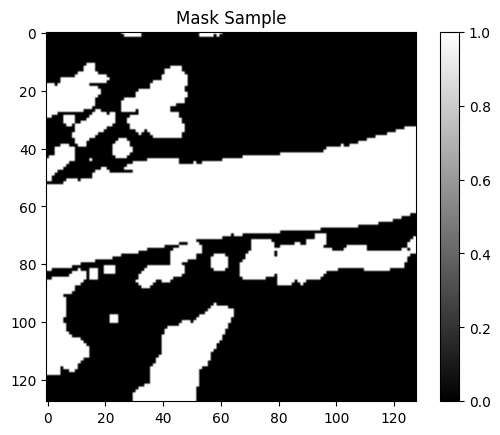

In [14]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(Y_train))  # Pick a random sample
plt.imshow(Y_train[idx], cmap="gray")
plt.title("Mask Sample")
plt.colorbar()
plt.show()


In [3]:
# Create and compile the model
model = unet_model(input_shape=(128, 128, 12), learning_rate=0.0001)

# Define training parameters
batch_size = 8
epochs = 50

# Train the model
history = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[IoUCallback()],
    verbose=1
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - iou_metric: 0.3692 - loss: 0.5702
Epoch 1: IoU = 0.4187
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 669ms/step - iou_metric: 0.3708 - loss: 0.5676 - val_iou_metric: 0.2794 - val_loss: 0.3643
Epoch 2/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - iou_metric: 0.4954 - loss: 0.3509
Epoch 2: IoU = 0.4859
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - iou_metric: 0.4948 - loss: 0.3510 - val_iou_metric: 0.3264 - val_loss: 0.3358
Epoch 3/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - iou_metric: 0.5296 - loss: 0.3364
Epoch 3: IoU = 0.4841
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - iou_metric: 0.5268 - loss: 0.3383 - val_iou_metric: 0.3552 - val_loss: 0.3164
Epoch 4/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - iou_metric: 0.4928 - loss: 0.3212
Epoch 4: IoU = 0.4860
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - iou_metric: 0.4923 - loss: 0.3216 - val_iou_metric: 0.3976 - val_loss: 0.2854
Epoch 5/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - iou_metric: 0.5067 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


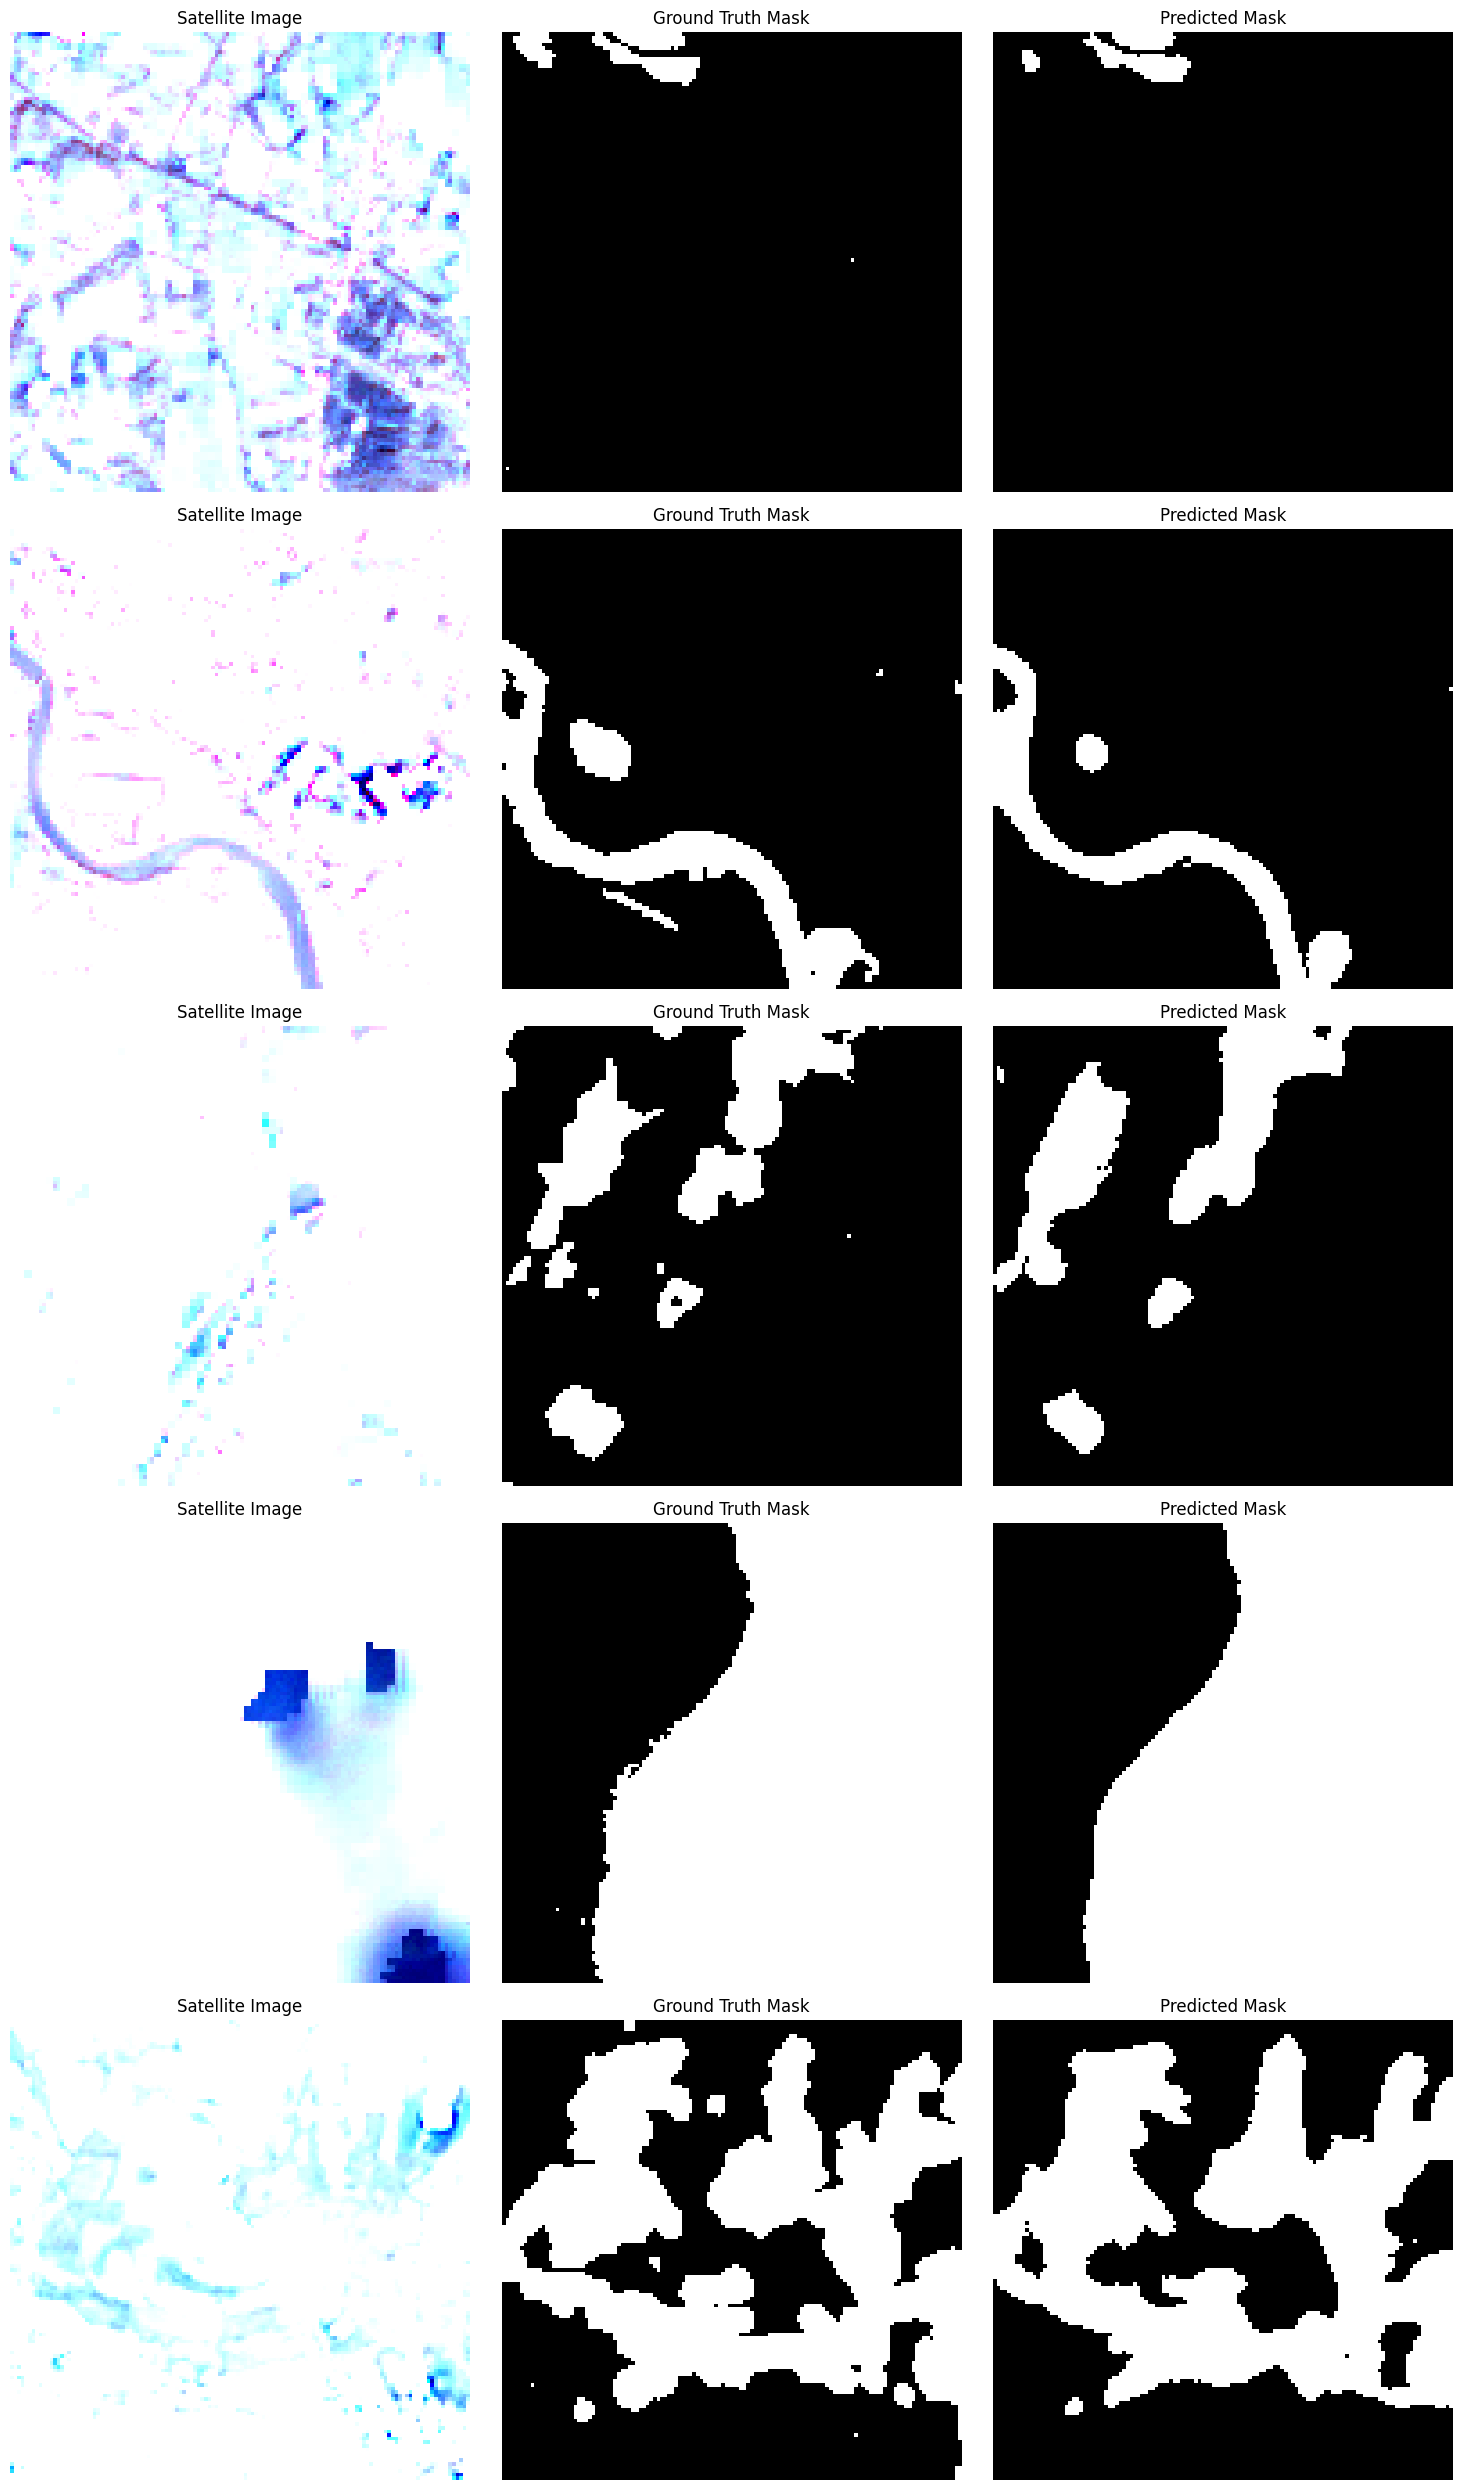

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(model, X, Y, num_samples=5, threshold=0.5):
    indices = np.random.choice(len(X), num_samples, replace=False)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices):
        image = X[idx]
        true_mask = Y[idx]

        # Predict flood mask using the trained model
        pred_mask = model.predict(image[np.newaxis, ...])  # Add batch dimension
        pred_mask = pred_mask.squeeze()  # Remove extra dimensions

        # Threshold to get binary mask (if needed)
        pred_mask = (pred_mask > threshold).astype(np.uint8)

        # Show satellite image
        axes[i, 0].imshow(image[:, :, :3])  # First 3 channels as RGB
        axes[i, 0].set_title("Satellite Image")
        axes[i, 0].axis("off")

        # Show ground truth mask
        axes[i, 1].imshow(true_mask.squeeze(), cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        # Show predicted mask
        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Call function
show_predictions(model, X_train, Y_train)


In [4]:
# Make predictions
Y_pred = model.predict(X_train, batch_size=8)  # Predict for all images

# Threshold predictions to convert them into binary masks (0 or 1)
Y_pred_binary = (Y_pred > 0.5).astype(np.uint8)

# Function to compute IoU for all images collectively
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    iou = intersection / (union + 1e-6)  # Adding a small value to avoid division by zero
    return iou

# Compute IoU for all images collectively
iou_score = compute_iou(Y_train, Y_pred_binary)
print(f"Overall IoU for all images: {iou_score:.4f}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
Overall IoU for all images: 0.8390


# Pretraining


# DeepLabV3

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import cv2
import numpy as np
import glob
import os
import tifffile as tiff
from PIL import Image

# Set image size
IMG_SIZE = (128, 128)


def load_image(image_path):
    try:
        image = tiff.imread(image_path).astype(np.float32)  # Convert to float32
        if image.ndim == 3 and image.shape[-1] >= 3:
            image = image[:, :, :[2,3,4]]  # Ensure 3 channels
        else:
            return None  # Skip invalid images
        
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)  # Normalize [0,1]
        image = cv2.resize(image, IMG_SIZE)  # Resize to (128, 128)
        return image
    except Exception as e:
        return None


# Load Mask Function (Binary Segmentation)
def load_mask(mask_path):
    try:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        if mask is None:
            return None
        mask = cv2.resize(mask, IMG_SIZE)  # Resize
        return np.expand_dims(mask.astype(np.float32), axis=-1)  # Remove normalization
    except Exception as e:
        return None

# File paths
image_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/images/*.tif"))
mask_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/labels/*.png"))

# Ensure images and masks match
image_names = {os.path.basename(p).split(".")[0] for p in image_paths}
mask_names = {os.path.basename(p).split(".")[0] for p in mask_paths}

image_paths_filtered = [p for p in image_paths if os.path.basename(p).split(".")[0] in mask_names]
mask_paths_filtered = [p for p in mask_paths if os.path.basename(p).split(".")[0] in image_names]

# Define Dataset Class
class SatelliteDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = load_image(self.image_paths[idx])
        mask = load_mask(self.mask_paths[idx])
        if image is None or mask is None:
            return self.__getitem__((idx + 1) % len(self.image_paths))  # Skip invalid data

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert to (C, H, W)
        mask = torch.tensor(mask, dtype=torch.float32).squeeze(-1)  # Convert to (H, W)
        return image, mask

# Create Dataset & DataLoader
dataset = SatelliteDataset(image_paths_filtered, mask_paths_filtered)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Load DeepLabV3 model from PyTorch Hub
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # Modify output layer for binary segmentation
model = model.to(device)

# Define Loss & Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary segmentation loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# Define IoU Calculation Function
def compute_iou(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()  # Convert logits to binary mask
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection / (union + 1e-8)).item()  # Avoid division by zero
    return iou

# Training Loop with IoU Tracking
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    total_iou = 0.0
    num_batches = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out'].squeeze(1)  # Remove extra dimension
        
        # Compute Loss
        loss = criterion(outputs, masks)
        # Backpropagation
        loss.backward()
        optimizer.step()

        # Compute IoU
        batch_iou = compute_iou(outputs, masks)
        total_iou += batch_iou
        num_batches += 1

        running_loss += loss.item()
    
    avg_loss = running_loss / num_batches
    avg_iou = total_iou / num_batches

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, IoU = {avg_iou:.4f}")

print("Training Complete!")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1: Loss = 0.5194, IoU = 0.2449
Epoch 2: Loss = 0.4550, IoU = 0.3605
Epoch 3: Loss = 0.4686, IoU = 0.3140
Epoch 4: Loss = 0.4194, IoU = 0.4380
Epoch 5: Loss = 0.4208, IoU = 0.4117
Epoch 6: Loss = 0.3637, IoU = 0.4921
Epoch 7: Loss = 0.3423, IoU = 0.5322
Epoch 8: Loss = 0.3130, IoU = 0.5626
Epoch 9: Loss = 0.2939, IoU = 0.5948
Epoch 10: Loss = 0.2428, IoU = 0.6495
Epoch 11: Loss = 0.2726, IoU = 0.5984
Epoch 12: Loss = 0.2668, IoU = 0.6160
Epoch 13: Loss = 0.3305, IoU = 0.5199
Epoch 14: Loss = 0.2502, IoU = 0.6241
Epoch 15: Loss = 0.2203, IoU = 0.6668
Epoch 16: Loss = 0.1894, IoU = 0.6848
Epoch 17: Loss = 0.1982, IoU = 0.6656
Epoch 18: Loss = 0.1772, IoU = 0.7148
Epoch 19: Loss = 0.1553, IoU = 0.7416
Epoch 20: Loss = 0.1417, IoU = 0.7518
Training Complete!


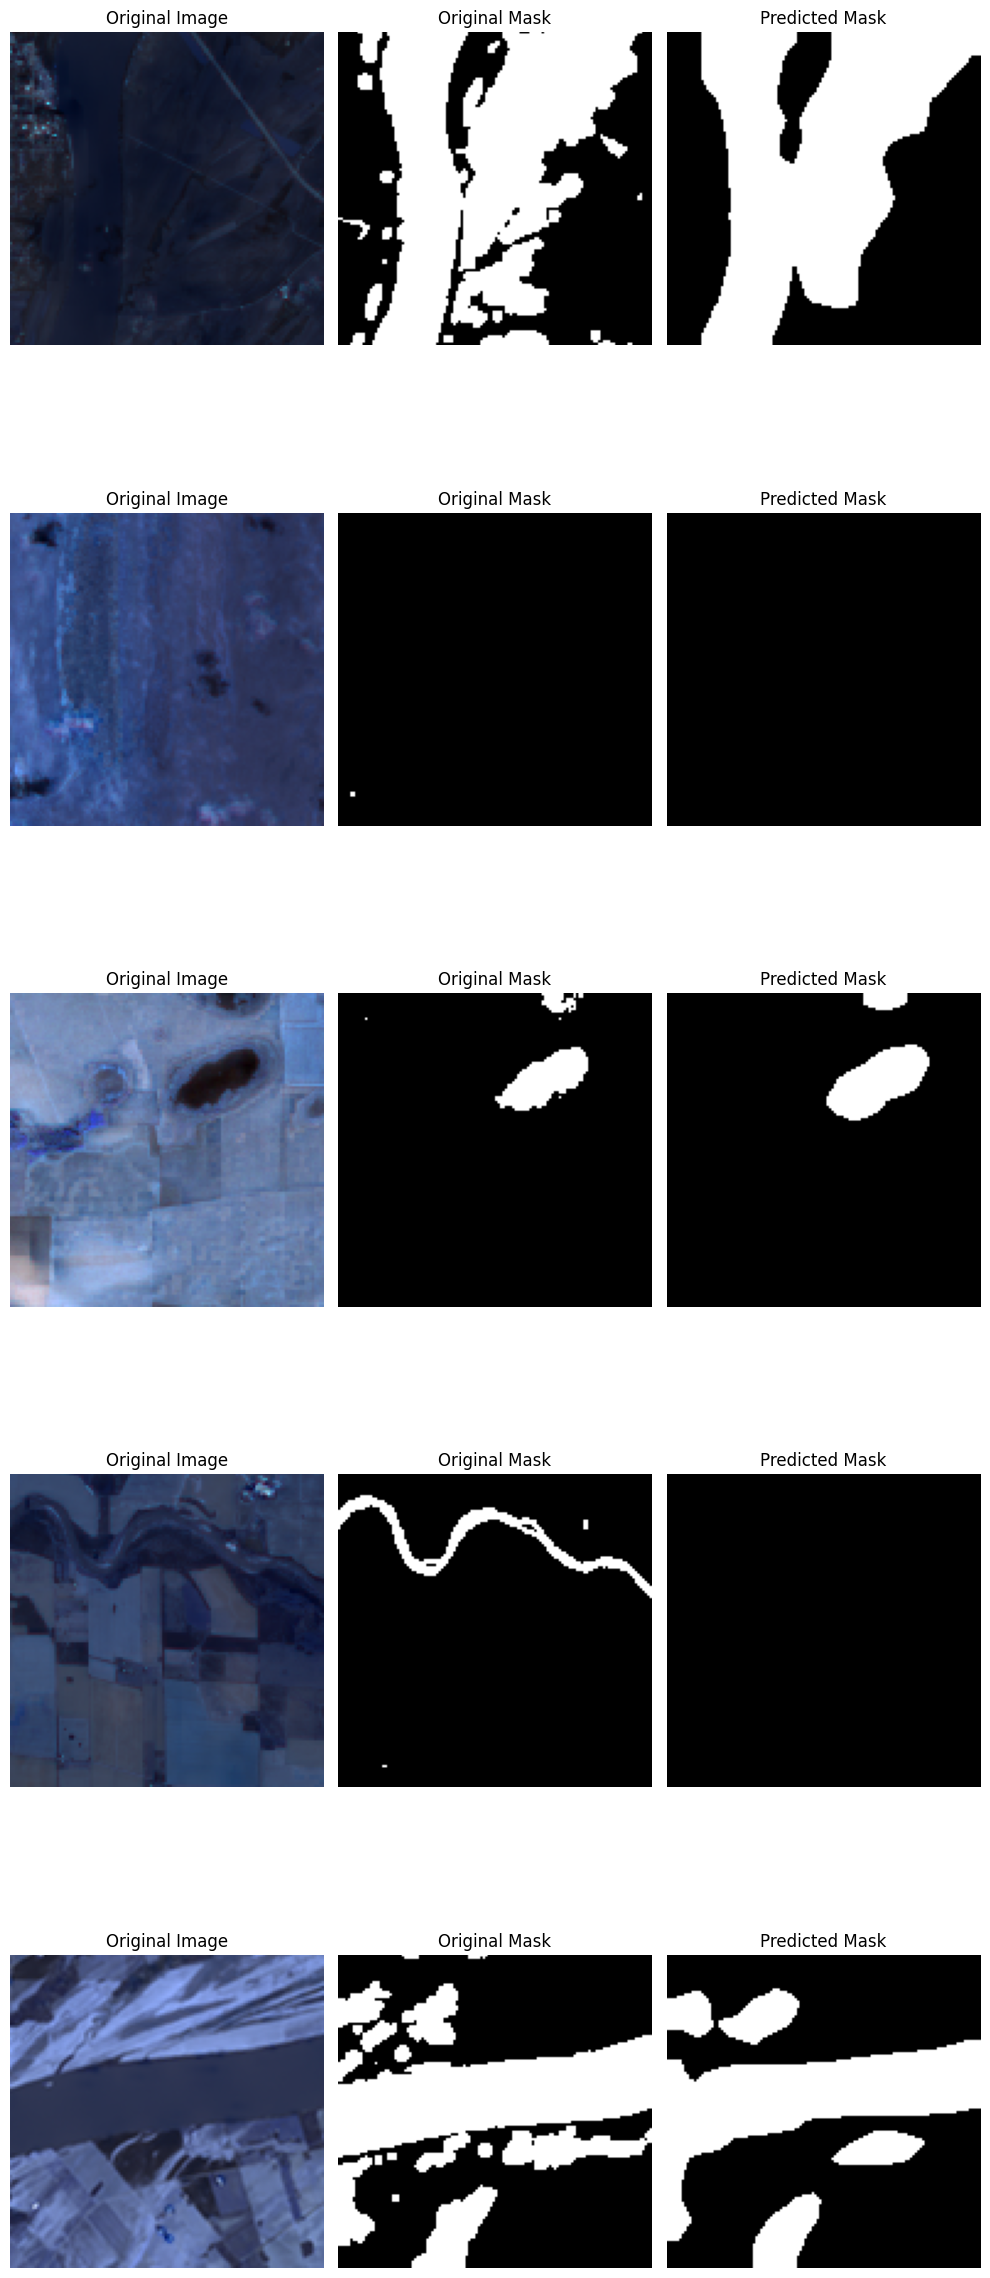

In [7]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, dataset, num_samples=5):
    model.eval()  # Set model to evaluation mode
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 5 * num_samples))

    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        
        with torch.no_grad():
            output = model(image)['out'].squeeze(0).squeeze(0).cpu().numpy()  # Get prediction
        
        pred_mask = (torch.sigmoid(torch.tensor(output)) > 0.5).float().numpy()  # Convert to binary

        # Convert tensor image back to numpy
        image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        mask_np = mask.cpu().numpy()

        # Plot images
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask_np, cmap="gray")
        axes[i, 1].set_title("Original Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function
visualize_predictions(model, dataset)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import cv2
import numpy as np
import glob
import os
import tifffile as tiff
from PIL import Image

# Set image size
IMG_SIZE = (128, 128)


# Load Mask Function (Binary Segmentation)
def load_mask(mask_path):
    try:
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Load all channels
        if mask is None:
            return None
        
        mask = mask[:, :, 3]  # Extract channels 2, 3, and 4
        mask = cv2.resize(mask, IMG_SIZE)  # Resize

        return mask.astype(np.float32)  # Keep original pixel values (0-255)
    except Exception as e:
        return None


# Load Mask Function (Binary Segmentation)
def load_mask(mask_path):
    try:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        if mask is None:
            return None
        mask = cv2.resize(mask, IMG_SIZE)  # Resize
        return np.expand_dims(mask.astype(np.float32), axis=-1)  # Remove normalization
    except Exception as e:
        return None

# File paths
image_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/images/*.tif"))
mask_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/labels/*.png"))

# Ensure images and masks match
image_names = {os.path.basename(p).split(".")[0] for p in image_paths}
mask_names = {os.path.basename(p).split(".")[0] for p in mask_paths}

image_paths_filtered = [p for p in image_paths if os.path.basename(p).split(".")[0] in mask_names]
mask_paths_filtered = [p for p in mask_paths if os.path.basename(p).split(".")[0] in image_names]

# Define Dataset Class
class SatelliteDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = load_image(self.image_paths[idx])
        mask = load_mask(self.mask_paths[idx])
        if image is None or mask is None:
            return self.__getitem__((idx + 1) % len(self.image_paths))  # Skip invalid data

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert to (C, H, W)
        mask = torch.tensor(mask, dtype=torch.float32).squeeze(-1)  # Convert to (H, W)
        return image, mask

# Create Dataset & DataLoader
dataset = SatelliteDataset(image_paths_filtered, mask_paths_filtered)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Load DeepLabV3 model from PyTorch Hub
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # Modify output layer for binary segmentation
model = model.to(device)

# Define Loss & Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary segmentation loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# Define IoU Calculation Function
def compute_iou(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()  # Convert logits to binary mask
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection / (union + 1e-8)).item()  # Avoid division by zero
    return iou

# Training Loop with IoU Tracking
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    total_iou = 0.0
    num_batches = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out'].squeeze(1)  # Remove extra dimension
        
        # Compute Loss
        loss = criterion(outputs, masks)
        # Backpropagation
        loss.backward()
        optimizer.step()

        # Compute IoU
        batch_iou = compute_iou(outputs, masks)
        total_iou += batch_iou
        num_batches += 1

        running_loss += loss.item()
    
    avg_loss = running_loss / num_batches
    avg_iou = total_iou / num_batches

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, IoU = {avg_iou:.4f}")

print("Training Complete!")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1: Loss = 0.5238, IoU = 0.1674
Epoch 2: Loss = 0.4358, IoU = 0.3806
Epoch 3: Loss = 0.3825, IoU = 0.4863
Epoch 4: Loss = 0.3693, IoU = 0.4607
Epoch 5: Loss = 0.3341, IoU = 0.5400
Epoch 6: Loss = 0.3061, IoU = 0.5549
Epoch 7: Loss = 0.3102, IoU = 0.5817
Epoch 8: Loss = 0.2590, IoU = 0.6332
Epoch 9: Loss = 0.2476, IoU = 0.6131
Epoch 10: Loss = 0.2567, IoU = 0.6356
Epoch 11: Loss = 0.2305, IoU = 0.6579
Epoch 12: Loss = 0.1983, IoU = 0.6797
Epoch 13: Loss = 0.1866, IoU = 0.7226
Epoch 14: Loss = 0.1709, IoU = 0.7353
Epoch 15: Loss = 0.1652, IoU = 0.7197
Epoch 16: Loss = 0.1445, IoU = 0.7454
Epoch 17: Loss = 0.1420, IoU = 0.7663
Epoch 18: Loss = 0.1613, IoU = 0.7357
Epoch 19: Loss = 0.1404, IoU = 0.7640
Epoch 20: Loss = 0.1349, IoU = 0.7753
Training Complete!


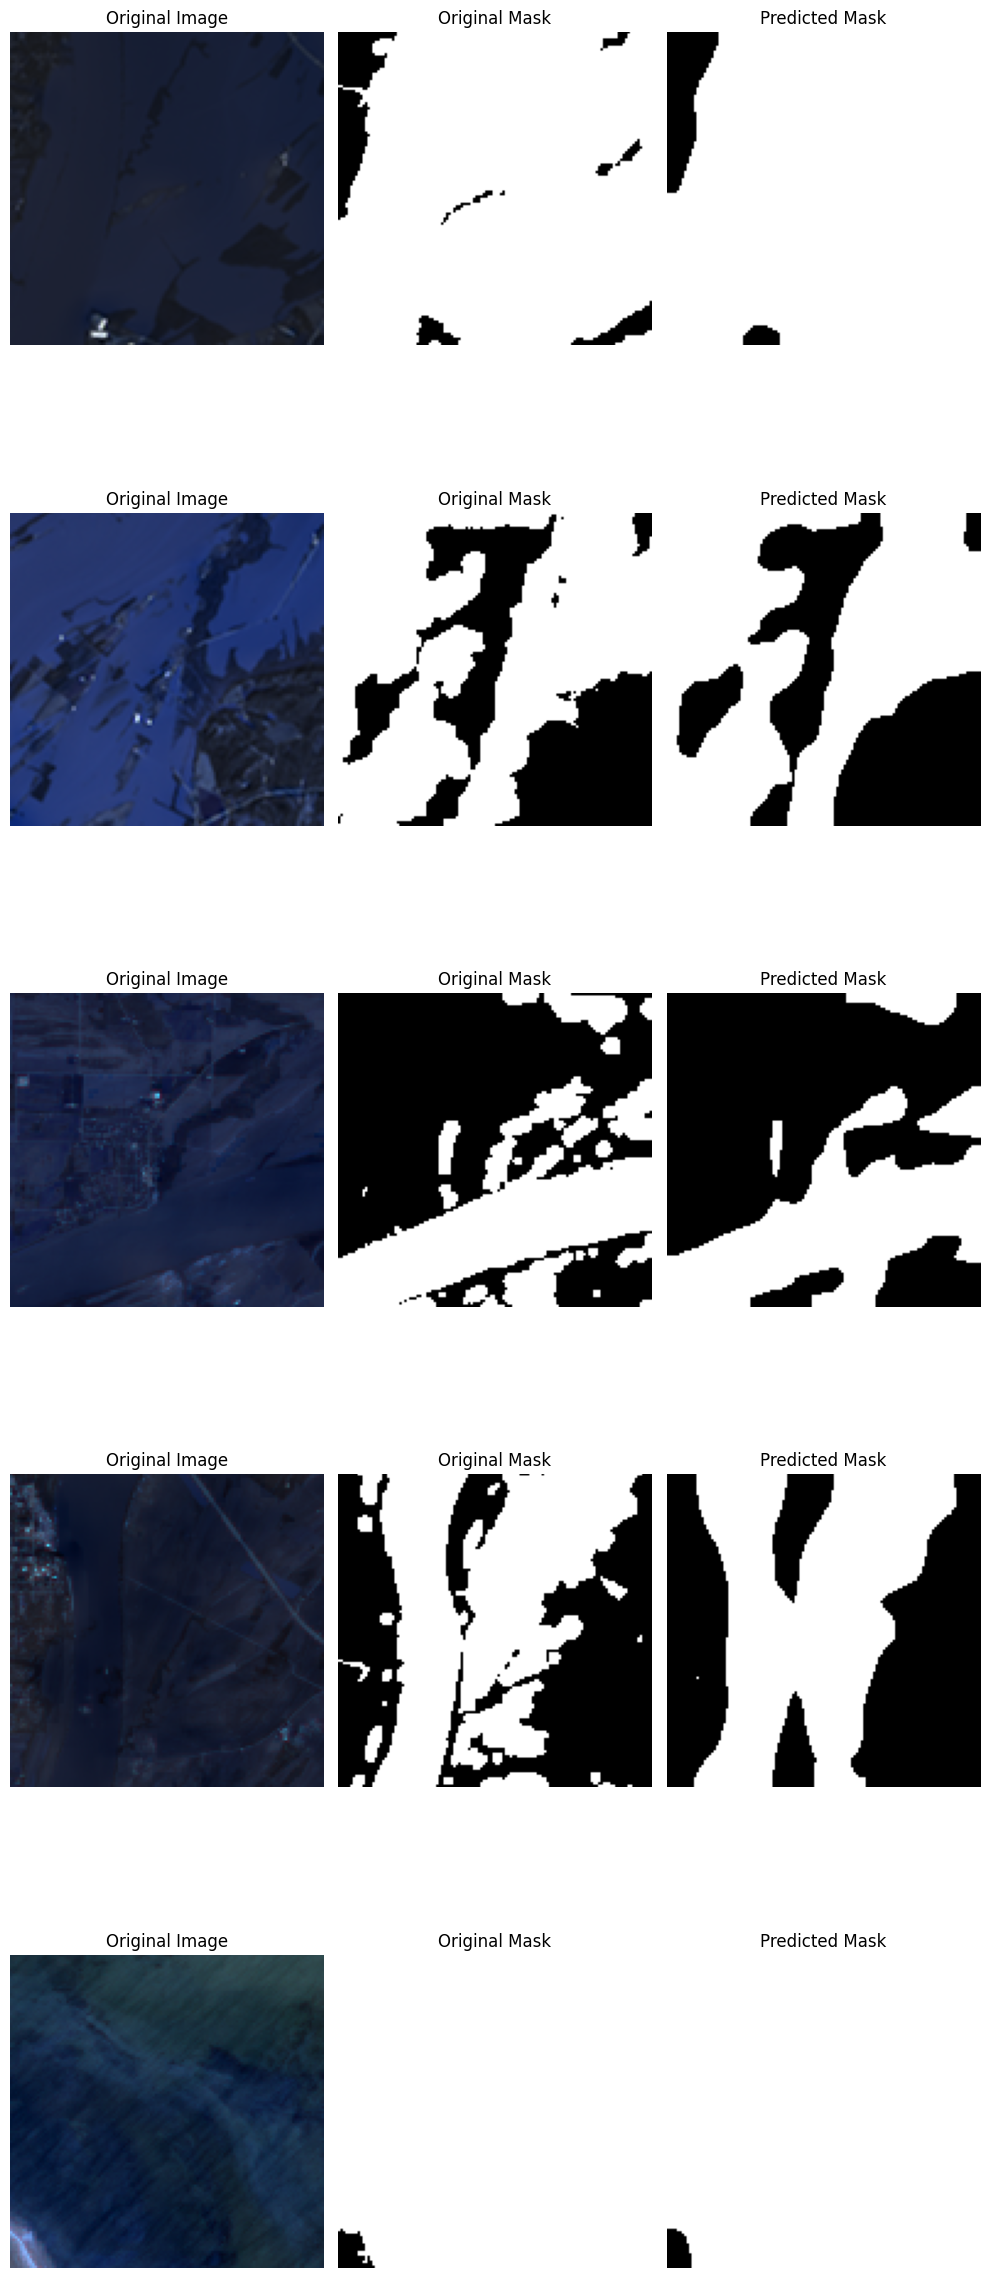

In [9]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, dataset, num_samples=5):
    model.eval()  # Set model to evaluation mode
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 5 * num_samples))

    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        
        with torch.no_grad():
            output = model(image)['out'].squeeze(0).squeeze(0).cpu().numpy()  # Get prediction
        
        pred_mask = (torch.sigmoid(torch.tensor(output)) > 0.5).float().numpy()  # Convert to binary

        # Convert tensor image back to numpy
        image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        mask_np = mask.cpu().numpy()

        # Plot images
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask_np, cmap="gray")
        axes[i, 1].set_title("Original Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function
visualize_predictions(model, dataset)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import cv2
import numpy as np
import glob
import os
import tifffile as tiff
from PIL import Image

# Set image size
IMG_SIZE = (128, 128)


def load_image(image_path):
    try:
        image = tiff.imread(image_path).astype(np.float32)  # Convert to float32
        if image.ndim == 3 and image.shape[-1] >= 3:
            image = image[:, :, [2, 1, 0]]  # BGR → RGB
  
        else:
            return None  # Skip invalid images
        
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)  # Normalize [0,1]
        image = cv2.resize(image, IMG_SIZE)  # Resize to (128, 128)
        return image
    except Exception as e:
        return None


# Load Mask Function (Binary Segmentation)
def load_mask(mask_path):
    try:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        if mask is None:
            return None
        mask = cv2.resize(mask, IMG_SIZE)  # Resize
        return np.expand_dims(mask.astype(np.float32), axis=-1)  # Remove normalization
    except Exception as e:
        return None

# File paths
image_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/images/*.tif"))
mask_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/labels/*.png"))

# Ensure images and masks match
image_names = {os.path.basename(p).split(".")[0] for p in image_paths}
mask_names = {os.path.basename(p).split(".")[0] for p in mask_paths}

image_paths_filtered = [p for p in image_paths if os.path.basename(p).split(".")[0] in mask_names]
mask_paths_filtered = [p for p in mask_paths if os.path.basename(p).split(".")[0] in image_names]

# Define Dataset Class
class SatelliteDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        max_attempts = len(self.image_paths)  # Avoid infinite loop
        attempts = 0

        while attempts < max_attempts:
            image = load_image(self.image_paths[idx])
            mask = load_mask(self.mask_paths[idx])

            if image is not None and mask is not None:
                image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert to (C, H, W)
                mask = torch.tensor(mask, dtype=torch.float32).squeeze(-1)  # Convert to (H, W)
                return image, mask

            # Move to the next index
            idx = (idx + 1) % len(self.image_paths)
            attempts += 1

        raise RuntimeError("All images/masks in the dataset are invalid.")




# Create Dataset & DataLoader
dataset = SatelliteDataset(image_paths_filtered, mask_paths_filtered)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Load DeepLabV3 model from PyTorch Hub
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # Modify output layer for binary segmentation
model = model.to(device)

# Define Loss & Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary segmentation loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# Define IoU Calculation Function
def compute_iou(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()  # Convert logits to binary mask
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection / (union + 1e-8)).item()  # Avoid division by zero
    return iou

# Training Loop with IoU Tracking
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    total_iou = 0.0
    num_batches = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out'].squeeze(1)  # Remove extra dimension
        
        # Compute Loss
        loss = criterion(outputs, masks)
        # Backpropagation
        loss.backward()
        optimizer.step()

        # Compute IoU
        batch_iou = compute_iou(outputs, masks)
        total_iou += batch_iou
        num_batches += 1

        running_loss += loss.item()
    
    avg_loss = running_loss / num_batches
    avg_iou = total_iou / num_batches

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, IoU = {avg_iou:.4f}")

print("Training Complete!")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1: Loss = 0.4876, IoU = 0.2897
Epoch 2: Loss = 0.4215, IoU = 0.4269
Epoch 3: Loss = 0.3789, IoU = 0.4718
Epoch 4: Loss = 0.3722, IoU = 0.4845
Epoch 5: Loss = 0.3398, IoU = 0.5214
Epoch 6: Loss = 0.3109, IoU = 0.5529
Epoch 7: Loss = 0.2706, IoU = 0.5999
Epoch 8: Loss = 0.2495, IoU = 0.6319
Epoch 9: Loss = 0.2447, IoU = 0.6481
Epoch 10: Loss = 0.2471, IoU = 0.6518
Epoch 11: Loss = 0.2579, IoU = 0.6259
Epoch 12: Loss = 0.2524, IoU = 0.6346
Epoch 13: Loss = 0.2230, IoU = 0.6572
Epoch 14: Loss = 0.2230, IoU = 0.6715
Epoch 15: Loss = 0.2819, IoU = 0.6207
Epoch 16: Loss = 0.2461, IoU = 0.6547
Epoch 17: Loss = 0.1955, IoU = 0.6993
Epoch 18: Loss = 0.1738, IoU = 0.7274
Epoch 19: Loss = 0.1593, IoU = 0.7355
Epoch 20: Loss = 0.1422, IoU = 0.7423
Training Complete!


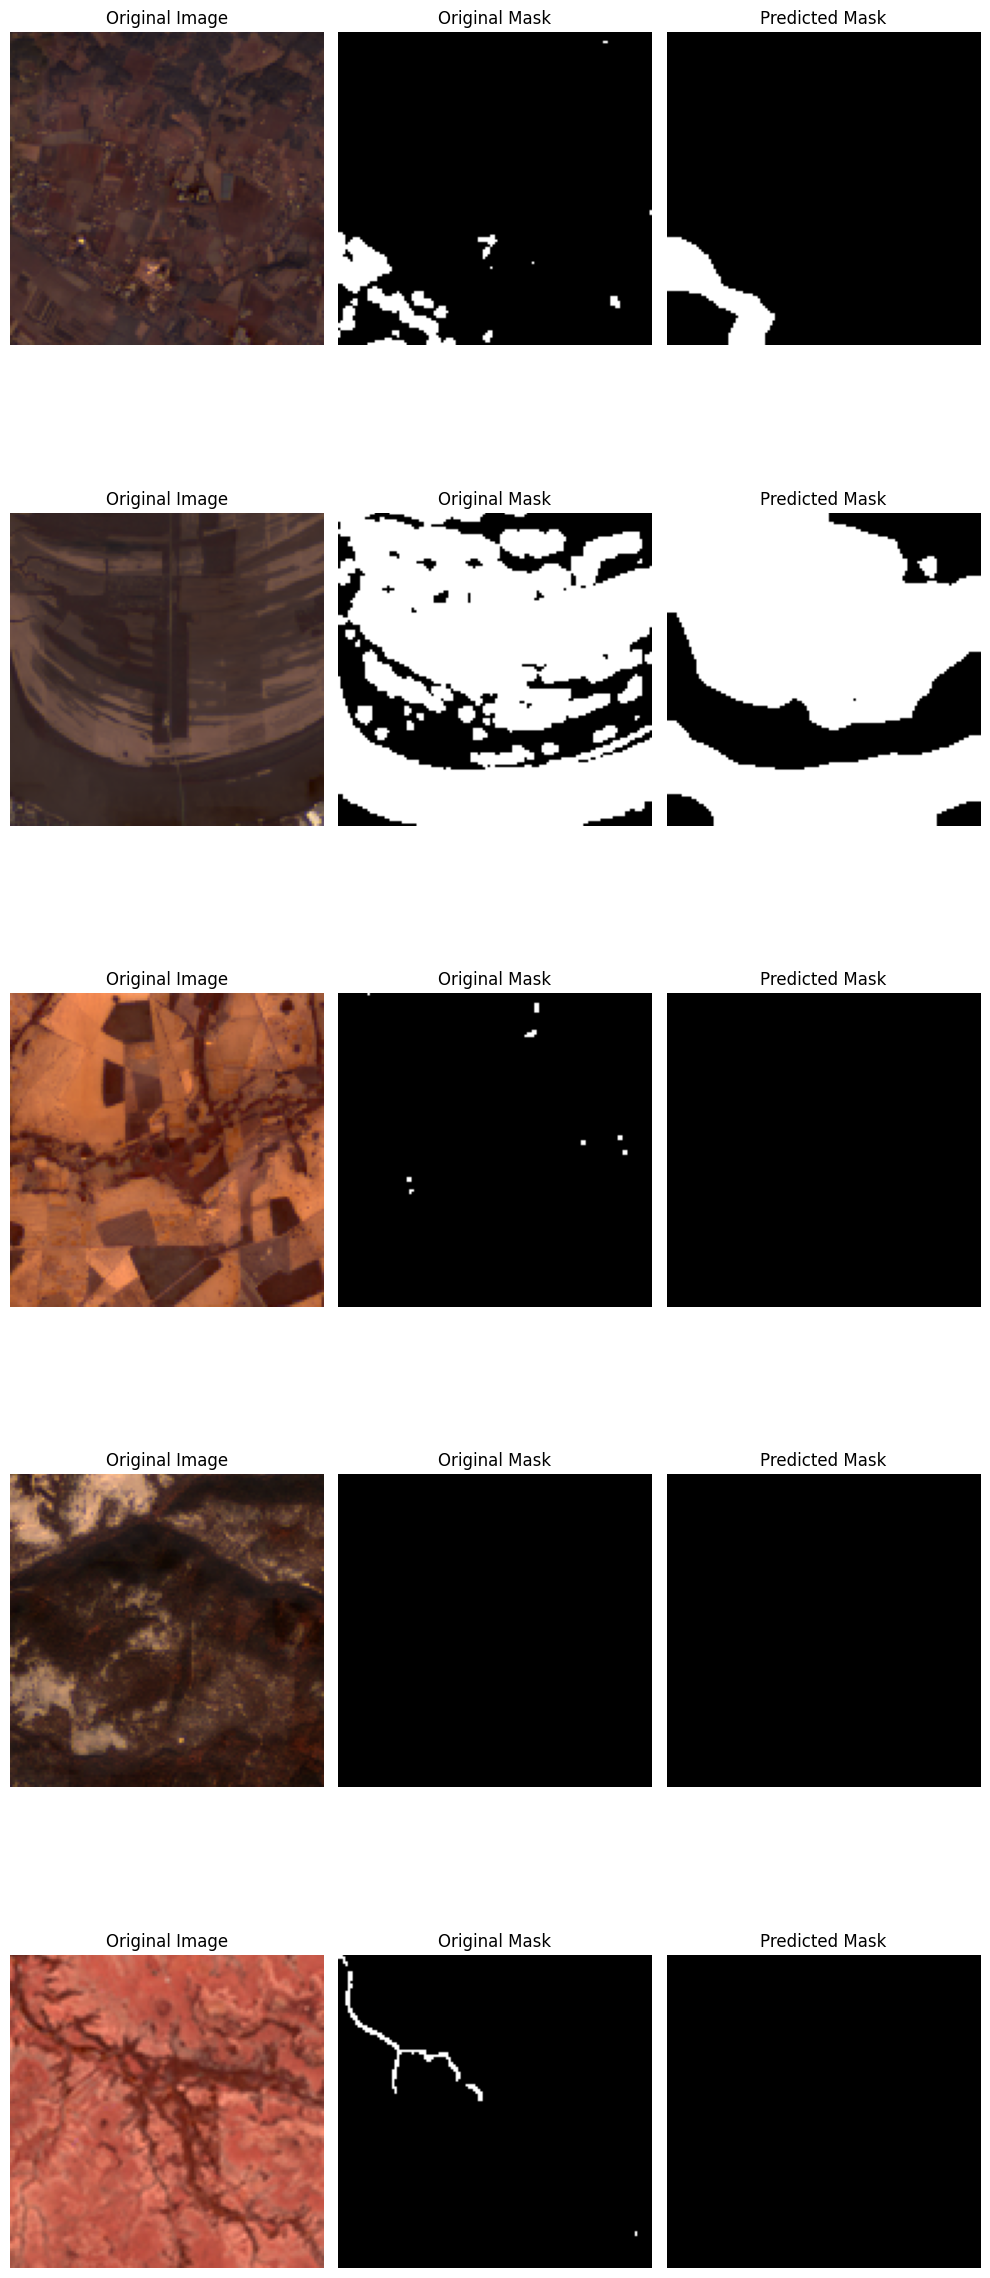

In [6]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, dataset, num_samples=5):
    model.eval()  # Set model to evaluation mode
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 5 * num_samples))

    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        
        with torch.no_grad():
            output = model(image)['out'].squeeze(0).squeeze(0).cpu().numpy()  # Get prediction
        
        pred_mask = (torch.sigmoid(torch.tensor(output)) > 0.5).float().numpy()  # Convert to binary

        # Convert tensor image back to numpy
        image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        mask_np = mask.cpu().numpy()

        # Plot images
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask_np, cmap="gray")
        axes[i, 1].set_title("Original Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function
visualize_predictions(model, dataset)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import cv2
import numpy as np
import glob
import os
import tifffile as tiff
from PIL import Image

# Set image size
IMG_SIZE = (128, 128)


def load_image(image_path):
    try:
        image = tiff.imread(image_path).astype(np.float32)  # Convert to float32
        if image.ndim == 3 and image.shape[-1] >= 3:
            image = image[:, :, [2, 1, 0]]  # BGR → RGB
  
        else:
            return None  # Skip invalid images
        
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)  # Normalize [0,1]
        image = cv2.resize(image, IMG_SIZE)  # Resize to (128, 128)
        return image
    except Exception as e:
        return None


# Load Mask Function (Binary Segmentation)
def load_mask(mask_path):
    try:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        if mask is None:
            return None
        mask = cv2.resize(mask, IMG_SIZE)  # Resize
        return np.expand_dims(mask.astype(np.float32), axis=-1)  # Remove normalization
    except Exception as e:
        return None

# File paths
image_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/images/*.tif"))
mask_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/labels/*.png"))

# Ensure images and masks match
image_names = {os.path.basename(p).split(".")[0] for p in image_paths}
mask_names = {os.path.basename(p).split(".")[0] for p in mask_paths}

image_paths_filtered = [p for p in image_paths if os.path.basename(p).split(".")[0] in mask_names]
mask_paths_filtered = [p for p in mask_paths if os.path.basename(p).split(".")[0] in image_names]

# Define Dataset Class
class SatelliteDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = load_image(self.image_paths[idx])
        mask = load_mask(self.mask_paths[idx])
        if image is None or mask is None:
            return self.__getitem__((idx + 1) % len(self.image_paths))  # Skip invalid data

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert to (C, H, W)
        mask = torch.tensor(mask, dtype=torch.float32).squeeze(-1)  # Convert to (H, W)
        return image, mask

# Create Dataset & DataLoader
dataset = SatelliteDataset(image_paths_filtered, mask_paths_filtered)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Load DeepLabV3 model from PyTorch Hub
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # Modify output layer for binary segmentation
model = model.to(device)

# Define Loss & Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary segmentation loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# Define IoU Calculation Function
def compute_iou(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()  # Convert logits to binary mask
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection / (union + 1e-8)).item()  # Avoid division by zero
    return iou

# Training Loop with IoU Tracking
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    total_iou = 0.0
    num_batches = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out'].squeeze(1)  # Remove extra dimension
        
        # Compute Loss
        loss = criterion(outputs, masks)
        # Backpropagation
        loss.backward()
        optimizer.step()

        # Compute IoU
        batch_iou = compute_iou(outputs, masks)
        total_iou += batch_iou
        num_batches += 1

        running_loss += loss.item()
    
    avg_loss = running_loss / num_batches
    avg_iou = total_iou / num_batches

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, IoU = {avg_iou:.4f}")

print("Training Complete!")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1: Loss = 0.5211, IoU = 0.2273
Epoch 2: Loss = 0.4588, IoU = 0.3755
Epoch 3: Loss = 0.4380, IoU = 0.3936
Epoch 4: Loss = 0.3658, IoU = 0.5085
Epoch 5: Loss = 0.3440, IoU = 0.5175
Epoch 6: Loss = 0.3369, IoU = 0.5265
Epoch 7: Loss = 0.3377, IoU = 0.5256
Epoch 8: Loss = 0.2908, IoU = 0.5743
Epoch 9: Loss = 0.2770, IoU = 0.5888
Epoch 10: Loss = 0.2537, IoU = 0.6299
Epoch 11: Loss = 0.2185, IoU = 0.6490
Epoch 12: Loss = 0.2134, IoU = 0.6844
Epoch 13: Loss = 0.1882, IoU = 0.7004
Epoch 14: Loss = 0.1799, IoU = 0.7118
Epoch 15: Loss = 0.1596, IoU = 0.7020
Epoch 16: Loss = 0.1469, IoU = 0.7474
Epoch 17: Loss = 0.1691, IoU = 0.7379
Epoch 18: Loss = 0.1750, IoU = 0.7275
Epoch 19: Loss = 0.1848, IoU = 0.7119
Epoch 20: Loss = 0.1683, IoU = 0.7301
Training Complete!


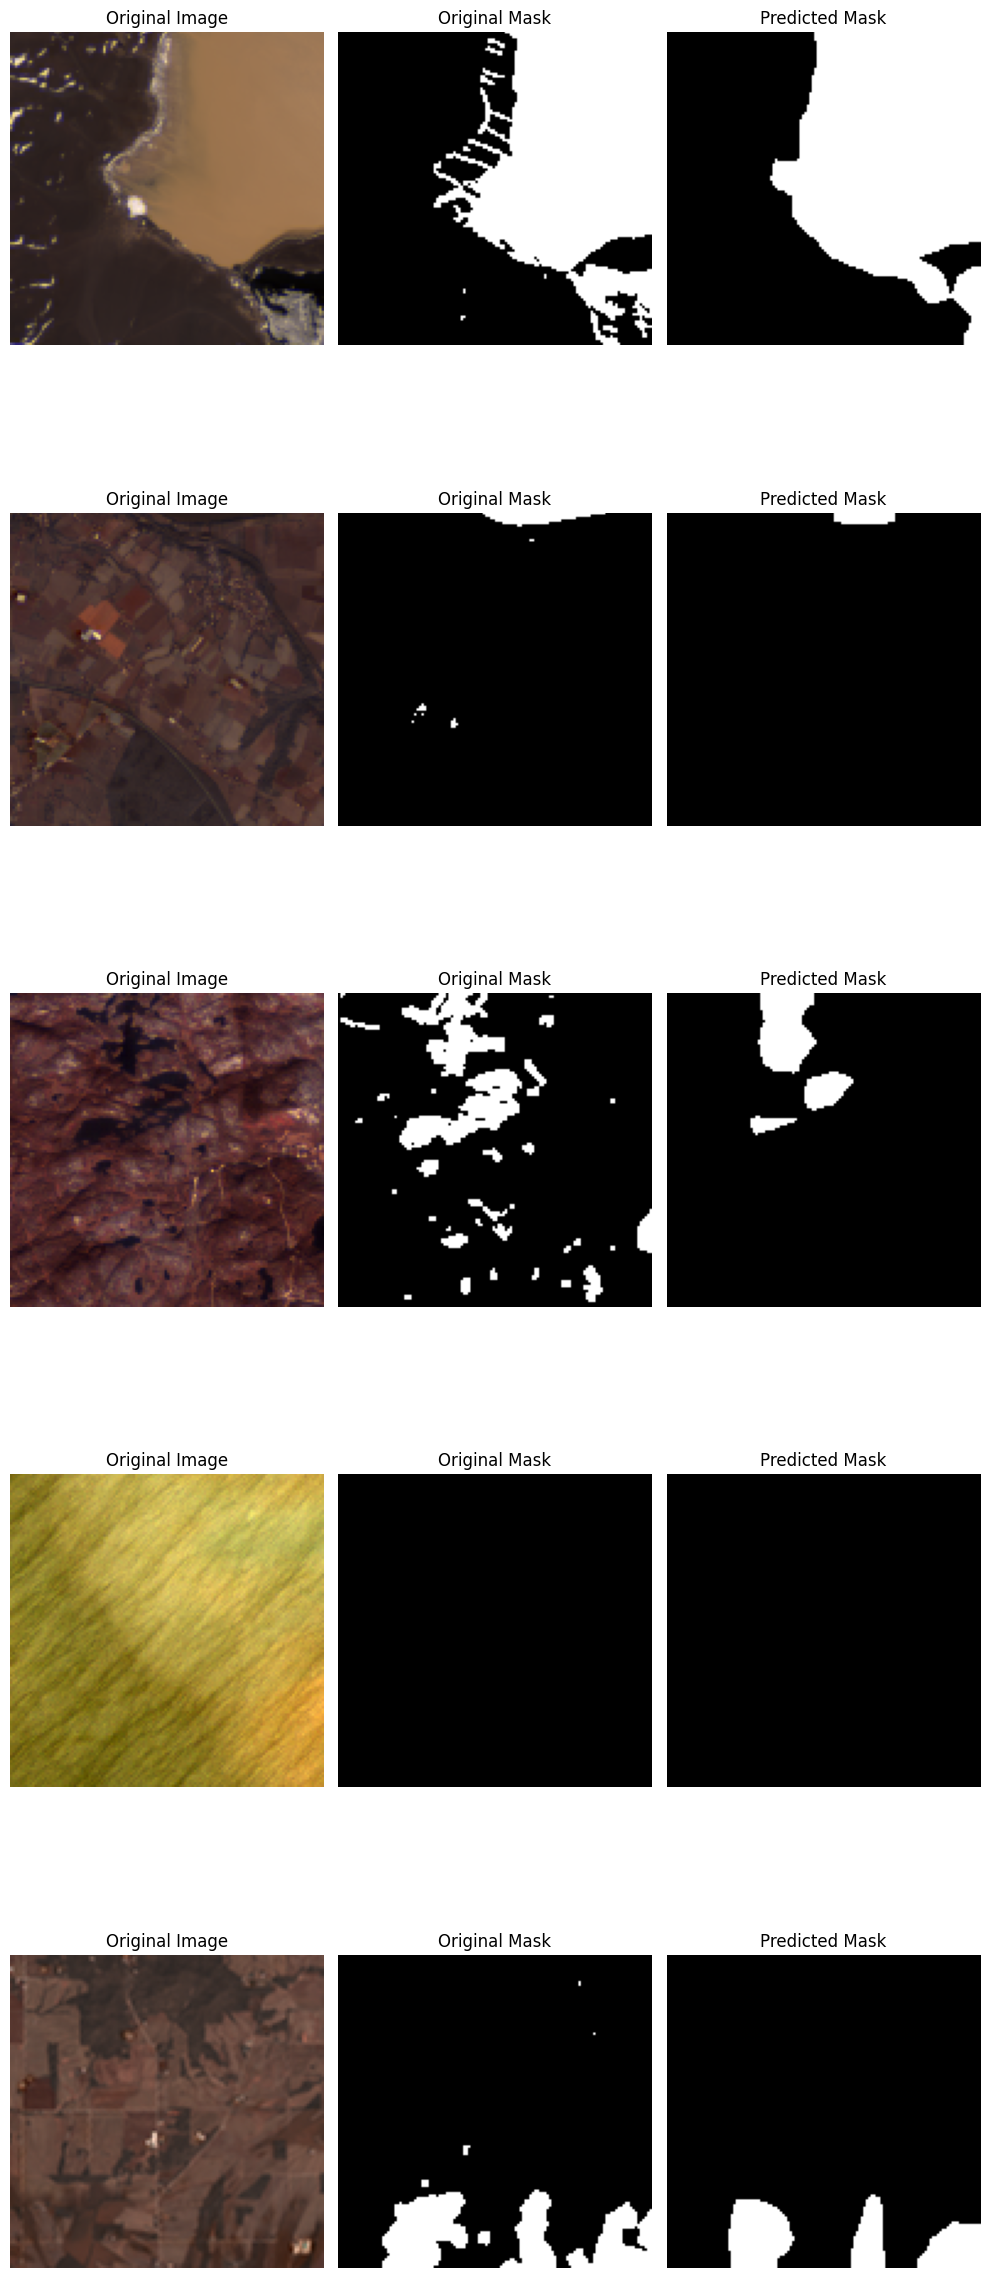

In [9]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, dataset, num_samples=5):
    model.eval()  # Set model to evaluation mode
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 5 * num_samples))

    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        
        with torch.no_grad():
            output = model(image)['out'].squeeze(0).squeeze(0).cpu().numpy()  # Get prediction
        
        pred_mask = (torch.sigmoid(torch.tensor(output)) > 0.5).float().numpy()  # Convert to binary

        # Convert tensor image back to numpy
        image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        mask_np = mask.cpu().numpy()

        # Plot images
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask_np, cmap="gray")
        axes[i, 1].set_title("Original Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function
visualize_predictions(model, dataset)


# Hugging Face SegFormer

In [82]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerImageProcessor
import tifffile as tiff
import cv2
import numpy as np
import glob
import os

# Load Segformer Processor
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Set image size
IMG_SIZE = (128, 128)


def load_image(image_path):
    try:
        image = tiff.imread(image_path).astype(np.float32)  # Convert to float32
        if image.ndim == 3 and image.shape[-1] >= 3:
            image = image[:, :, [2, 1, 0]]  # Convert BGR → RGB
        else:
            return None  # Skip invalid images
        
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)  # Normalize [0,1]
        image = cv2.resize(image, IMG_SIZE)  # Resize to (128, 128)
        return image
    except Exception as e:
        return None


def load_mask(mask_path):
    try:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        if mask is None:
            return None
        mask = cv2.resize(mask, IMG_SIZE)  # Resize
        return mask.astype(np.int64)  # Convert to integer class labels
    except Exception as e:
        return None


# File paths
image_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/images/*.tif"))
mask_paths = sorted(glob.glob("/kaggle/input/satalite1/satalite data/data/labels/*.png"))

# Ensure images and masks match
image_names = {os.path.basename(p).split(".")[0] for p in image_paths}
mask_names = {os.path.basename(p).split(".")[0] for p in mask_paths}

image_paths_filtered = [p for p in image_paths if os.path.basename(p).split(".")[0] in mask_names]
mask_paths_filtered = [p for p in mask_paths if os.path.basename(p).split(".")[0] in image_names]


# Define Dataset
class SatelliteDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = load_image(self.image_paths[idx])
        mask = load_mask(self.mask_paths[idx])

        if image is None or mask is None:
            return self.__getitem__((idx + 1) % len(self.image_paths))  # Skip bad samples
        
        # Convert to PIL Image (SegFormer expects PIL inputs)
        image = Image.fromarray((image * 255).astype(np.uint8))  # Convert [0,1] → [0,255]

        # Process input
        encoded_inputs = self.processor(images=image, segmentation_maps=mask, return_tensors="pt")

        return {
            "pixel_values": encoded_inputs["pixel_values"].squeeze(),
            "labels": encoded_inputs["labels"].squeeze()
        }


# Create DataLoader
dataset = SatelliteDataset(image_paths_filtered, mask_paths_filtered, processor)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)




In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

# Fix CUDA launch issues for debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Define a segmentation model (Replace this with your actual model)
class SimpleSegmentationModel(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleSegmentationModel, self).__init__()
        self.encoder = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Example encoder
        self.decoder = nn.Conv2d(16, num_classes, kernel_size=3, padding=1)  # Output logits

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return {"logits": x}  # Keep consistent with Hugging Face-style outputs

# Initialize the model
num_classes = 2  # Binary segmentation
model = SimpleSegmentationModel(num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Loss & Optimizer
criterion = torch.nn.BCEWithLogitsLoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Now the optimizer works because `model` is defined!

# IoU Calculation Function
def compute_iou(preds, labels, num_classes=2):
    iou_per_class = []
    
    for class_idx in range(num_classes):
        pred_class = preds == class_idx
        label_class = labels == class_idx

        intersection = (pred_class & label_class).sum().float()
        union = (pred_class | label_class).sum().float()

        if union == 0:
            iou = torch.tensor(1.0)  # If no class pixels, assume IoU = 1
        else:
            iou = intersection / union
        iou_per_class.append(iou)

    return torch.mean(torch.stack(iou_per_class))  # Average IoU across classes

In [93]:
import torch
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model.to(device)
model.train()

# Number of classes
NUM_CLASSES = 2  

# Define Dice Loss function
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)  # Sigmoid activation
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice  # Since we minimize loss

# Binary segmentation: Use Dice Loss + BCE
criterion = lambda pred, target: dice_loss(pred, target) + F.binary_cross_entropy_with_logits(pred, target)

# Use AdamW instead of SGD (Better weight updates)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

num_epochs = 20

# IoU Calculation Function
def compute_iou(preds, labels, num_classes):
    iou_per_class = []
    
    for class_idx in range(num_classes):
        pred_class = preds == class_idx
        label_class = labels == class_idx
        
        intersection = (pred_class & label_class).sum().float()
        union = (pred_class | label_class).sum().float()
        
        if union == 0:
            iou_per_class.append(torch.tensor(1.0, device=device))  # Avoid division by zero
        else:
            iou_per_class.append(intersection / union)
    
    return torch.mean(torch.stack(iou_per_class))  # Mean IoU across classes

# Training Loop
for epoch in range(num_epochs):
    total_loss = 0.0
    total_iou = 0.0

    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device)  
        labels = batch["labels"].to(device).float()  
        labels = labels / 255.0  

        # Forward pass
        outputs = model(pixel_values)["logits"]  

        preds = torch.argmax(outputs, dim=1)  

        # Resize labels & Ensure binary values
        labels_resized = F.interpolate(labels.unsqueeze(1), size=outputs.shape[-2:], mode="nearest")
        labels_resized = (labels_resized > 0.5).float()  # Threshold to ensure binary segmentation

        # Compute IoU
        iou = compute_iou(preds, labels_resized.long().squeeze(1), num_classes=NUM_CLASSES)

        # Compute Loss
        loss = criterion(outputs[:, 1, :, :].unsqueeze(1), labels_resized.float())  

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_iou += iou.item()

    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - IoU: {avg_iou:.4f}")

print("Training Complete!")


Epoch 1/20 - Loss: 4.1578 - IoU: 0.4232
Epoch 2/20 - Loss: 2.3282 - IoU: 0.5204
Epoch 3/20 - Loss: 2.1631 - IoU: 0.5184
Epoch 4/20 - Loss: 1.2951 - IoU: 0.5711
Epoch 5/20 - Loss: 1.5552 - IoU: 0.5570
Epoch 6/20 - Loss: 1.5965 - IoU: 0.5443
Epoch 7/20 - Loss: 1.0879 - IoU: 0.5826
Epoch 8/20 - Loss: 1.2084 - IoU: 0.5674
Epoch 9/20 - Loss: 1.3129 - IoU: 0.5765
Epoch 10/20 - Loss: 1.0493 - IoU: 0.5891
Epoch 11/20 - Loss: 0.7726 - IoU: 0.6024
Epoch 12/20 - Loss: 0.6172 - IoU: 0.6076
Epoch 13/20 - Loss: 0.9599 - IoU: 0.5814
Epoch 14/20 - Loss: 0.7911 - IoU: 0.6089
Epoch 15/20 - Loss: 0.7410 - IoU: 0.5882
Epoch 16/20 - Loss: 0.5925 - IoU: 0.6135
Epoch 17/20 - Loss: 0.6750 - IoU: 0.5993
Epoch 18/20 - Loss: 0.6534 - IoU: 0.5881
Epoch 19/20 - Loss: 0.5480 - IoU: 0.5845
Epoch 20/20 - Loss: 0.6000 - IoU: 0.5730
Training Complete!


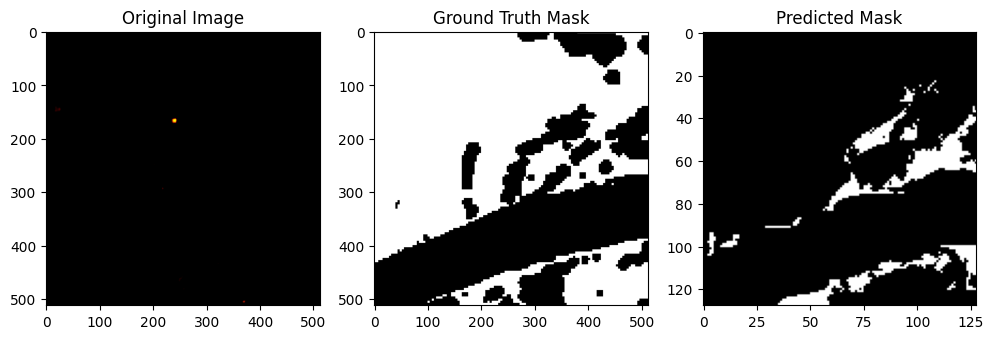

In [104]:
import matplotlib.pyplot as plt

# Example Predictions & Visualization
def visualize_sample(sample_batch):
    pixel_values = sample_batch["pixel_values"].to(device)
    labels = sample_batch["labels"].to(device).float()

    # Get Model Prediction
    model.eval()
    with torch.no_grad():
        logits = model(pixel_values)["logits"]
        preds = torch.sigmoid(logits).cpu().numpy()  # Convert to probability map
        preds = (preds > 0.5).astype(int)  # Thresholding for binary mask

    # Plot the Results
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Original Image
    axes[0].imshow(pixel_values[0].cpu().permute(1, 2, 0))  # Convert from tensor
    axes[0].set_title("Original Image")

    # Ground Truth Mask
    axes[1].imshow(labels[0].cpu().numpy(), cmap="gray")
    axes[1].set_title("Ground Truth Mask")

    # Predicted Mask
    axes[2].imshow(preds[0, 0], cmap="gray")
    axes[2].set_title("Predicted Mask")

    plt.show()


sample_batch = next(iter(train_loader))  # Get one batch
visualize_sample(sample_batch)